In [48]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
import hdbscan
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import re
import contractions

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/visheshgupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/visheshgupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [49]:
gold_df = pd.read_csv("gold-dataset-sinha-khandait.csv")
headlines_data = np.array(gold_df["News"])

In [50]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


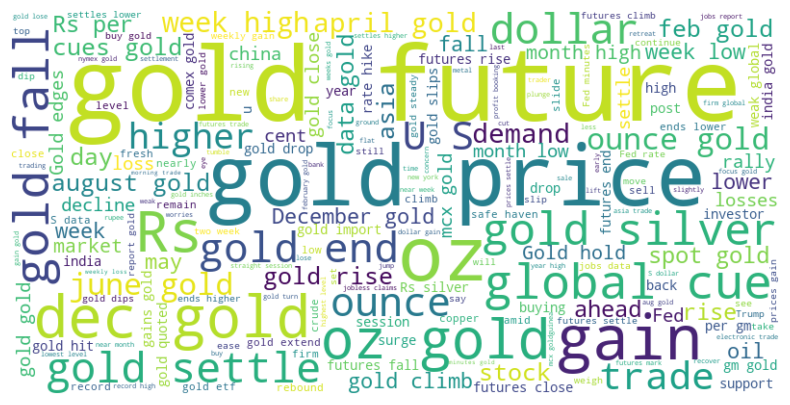

In [51]:
def generate_wordcloud(cluster_df, column="News"):
    text = " ".join(cluster_df[column].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        text
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


generate_wordcloud(gold_df)

In [52]:
def clean_text(text):
    # Expand contractions (e.g., "don't" → "do not")
    text = contractions.fix(text)

    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Remove special chars, punctuation
    text = re.sub(r"[^\w\s\']", "", text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespace
    text = " ".join(text.split())

    return text

In [53]:
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

In [54]:
gold_df["cleaned_News"] = gold_df["News"].apply(clean_text)
gold_df["lemmatized_News"] = gold_df["cleaned_News"].apply(lemmatize_text)

stop_words = set(stopwords.words("english"))
gold_df["final_News"] = gold_df["lemmatized_News"].apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)

In [55]:
headlines_data

array(['april gold down 20 cents to settle at $1,116.10/oz',
       'gold suffers third straight daily decline',
       'Gold futures edge up after two-session decline', ...,
       'Gold heading for worst week since November on rate hike worries',
       'august gold up $7.60 at $878.80 an ounce on nymex',
       'december gold down $1 at $749 an ounce on nymex'], dtype=object)

In [56]:
gold_df["final_News"]

0                      april gold 20 cent settle 111610 oz
1                 gold suffer third straight daily decline
2                      gold future edge twosession decline
3                  dent research gold 's day sun come soon
4        gold snap threeday rally trump lawmaker reach ...
                               ...                        
10565                        gold see fall 3week high week
10566    dominic frisby look like good time buy gold ne...
10567    gold head bad week since november rate hike worry
10568                    august gold 760 87880 ounce nymex
10569                      december gold 1 749 ounce nymex
Name: final_News, Length: 10570, dtype: object

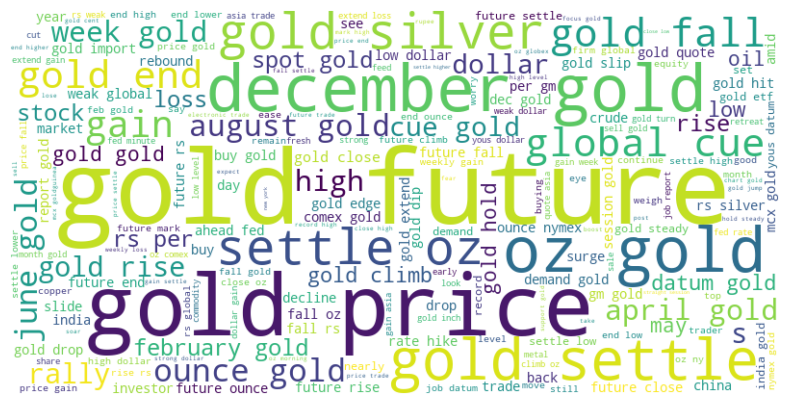

In [57]:
generate_wordcloud(gold_df, "final_News")

In [58]:
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = tfidf.fit_transform(gold_df["final_News"])

In [59]:
X_tfidf.shape

(10570, 5000)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(X_tfidf)

In [ ]:
cosine_df = pd.DataFrame(
    cosine_sim,
    columns=[f"H{i+1}" for i in range(len(headlines_data))],
    index=[f"H{i+1}" for i in range(len(headlines_data))],
)
cosine_df

H1        H2        H3        H4        H5        H6        H7  \
H1      1.000000  0.005636  0.006967  0.003683  0.003639  0.104062  0.005489   
H2      0.005636  1.000000  0.190921  0.004192  0.004142  0.005187  0.006247   
H3      0.006967  0.190921  1.000000  0.005182  0.005120  0.006412  0.007722   
H4      0.003683  0.004192  0.005182  1.000000  0.002707  0.003390  0.004082   
H5      0.003639  0.004142  0.005120  0.002707  1.000000  0.003349  0.004034   
...          ...       ...       ...       ...       ...       ...       ...   
H10566  0.007812  0.008891  0.010991  0.005810  0.005741  0.007189  0.116588   
H10567  0.003854  0.004386  0.005422  0.002867  0.002832  0.003547  0.004272   
H10568  0.004656  0.005299  0.006551  0.003463  0.003422  0.004285  0.005161   
H10569  0.006160  0.007011  0.008667  0.004582  0.004527  0.005669  0.006828   
H10570  0.008836  0.010056  0.012432  0.006572  0.006494  0.130271  0.009794   

              H8        H9       H10  ...    H10561    H10562  H10563  \
H1      0.008585  0.004458  0.142749  ...  0.006070  0.004628     0.0   
H2      0.009770  0.005074  0.004928  ...  0.006908  0.005267     0.0   
H3      0.105330  0.006272  0.006092  ...  0.008540  0.006512     0.0   
H4      0.006385  0.003316  0.003221  ...  0.004515  0.003442     0.0   
H5      0.006309  0.003276  0.003182  ...  0.004461  0.003401     0.0   
...          ...       ...       ...  ...       ...       ...     ...   
H10566  0.405651  0.007032  0.006830  ...  0.009575  0.077479     0.0   
H10567  0.006681  0.003470  0.003370  ...  0.004724  0.003602     0.0   
H10568  0.141170  0.004192  0.004071  ...  0.005707  0.004352     0.0   
H10569  0.010679  0.005545  0.005386  ...  0.007551  0.005757     0.0   
H10570  0.015319  0.007955  0.007726  ...  0.010831  0.008258     0.0   

          H10564    H10565    H10566    H10567    H10568    H10569    H10570  
H1      0.004191  0.050302  0.007812  0.003854  0.004656  0.006160  0.008836  
H2      0.004769  0.005508  0.008891  0.004386  0.005299  0.007011  0.010056  
H3      0.005896  0.006809  0.010991  0.005422  0.006551  0.008667  0.012432  
H4      0.003117  0.003600  0.005810  0.002867  0.003463  0.004582  0.006572  
H5      0.003080  0.003556  0.005741  0.002832  0.003422  0.004527  0.006494  
...          ...       ...       ...       ...       ...       ...       ...  
H10566  0.006611  0.007634  1.000000  0.006080  0.128458  0.009718  0.013939  
H10567  0.003262  0.003766  0.006080  1.000000  0.003624  0.004794  0.006877  
H10568  0.003940  0.004551  0.128458  0.003624  1.000000  0.005792  0.008309  
H10569  0.005213  0.006020  0.009718  0.004794  0.005792  1.000000  0.532050  
H10570  0.007478  0.008635  0.013939  0.006877  0.008309  0.532050  1.000000  

[10570 rows x 10570 columns]

In [ ]:
from sklearn.metrics import pairwise_distances

cosine_dist = pairwise_distances(X_tfidf, metric="cosine")

In [ ]:
len(cosine_dist[cosine_dist < 0])

0

In [ ]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=0.6, min_samples=2, metric="precomputed")
labels = dbscan.fit_predict(cosine_dist)

# Step 5: Group by cluster labels
grouped = {}
for i, label in enumerate(labels):
    grouped.setdefault(label, []).append(headlines_data[i])

In [69]:
len(grouped)

125

# K Means

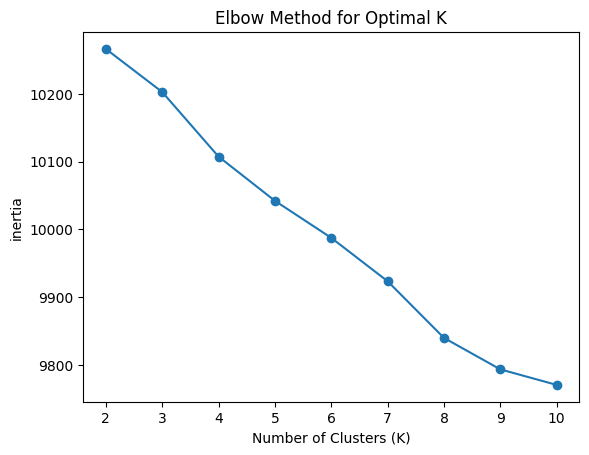

In [14]:
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

In [15]:
kmeans = KMeans(n_clusters=7, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_tfidf)

# Evaluate
silhouette = silhouette_score(X_tfidf, clusters_kmeans)
print(f"Silhouette Score (K-Means): {silhouette:.2f}")

Silhouette Score (K-Means): 0.02


/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


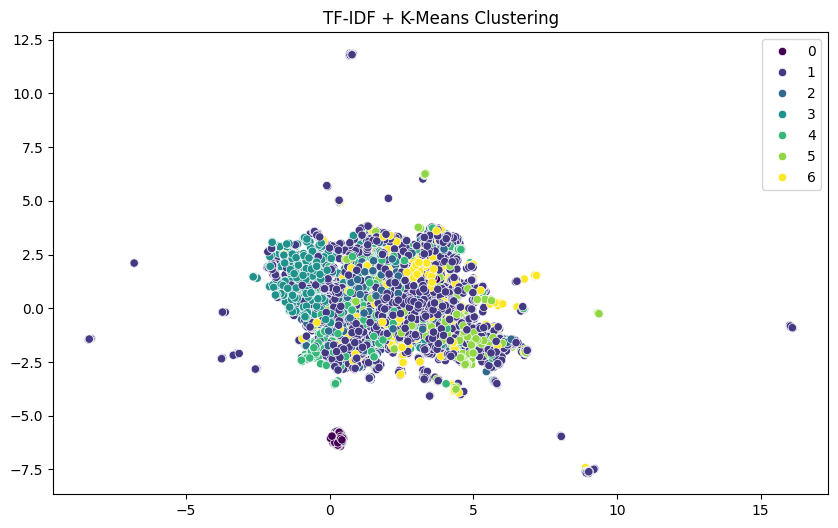

In [16]:
# really poor n_clusters above
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=clusters_kmeans, palette="viridis")
plt.title("TF-IDF + K-Means Clustering")
plt.show()

## DBSCAN

In [17]:
# redcue dimensions

reducer = umap.UMAP(n_components=20, random_state=42)
X_umap_tfidf = reducer.fit_transform(X_tfidf.toarray())

/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [18]:
X_umap_tfidf.shape

(10570, 20)

Best Parameters: {'eps': 0.25, 'min_samples': 7}
Best Silhouette Score: -0.18
Number of Clusters: 32
Noise Points: 9


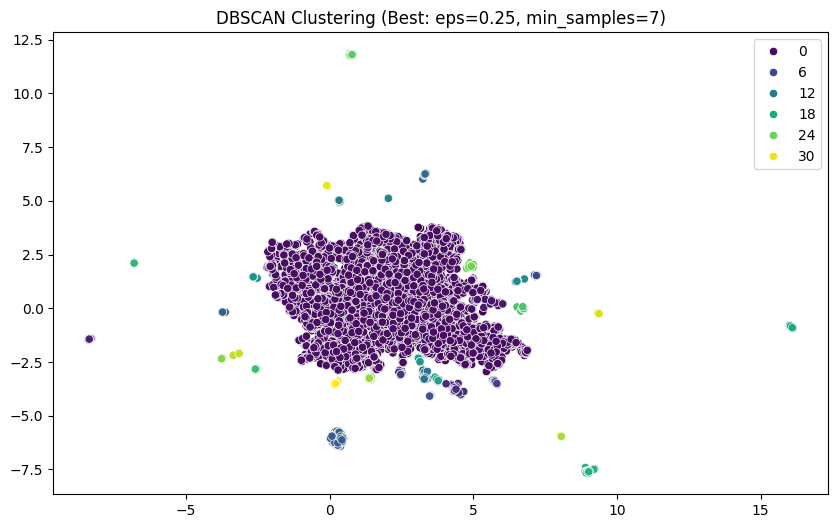

In [19]:
from itertools import product

from sklearn.cluster import DBSCAN


eps_values = [0.1, 0.15, 0.2, 0.25, 0.3]
min_samples_values = [3, 5, 7]

best_score = -1
best_params = {"eps": None, "min_samples": None}
best_clusters = None

# Grid Search
for eps, min_samples in product(eps_values, min_samples_values):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_umap)

    # Skip if all points are noise or only 1 cluster
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    if n_clusters < 2:
        continue

    # Calculate Silhouette Score (ignore noise points)
    mask = clusters != -1
    if sum(mask) > 0:  # Only compute if non-noise points exist
        score = silhouette_score(X_umap[mask], clusters[mask])
    else:
        continue

    # Update best parameters
    if score > best_score:
        best_score = score
        best_params = {"eps": eps, "min_samples": min_samples}
        best_clusters = clusters

# Results
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score:.2f}")
print(
    f"Number of Clusters: {len(set(best_clusters)) - (1 if -1 in best_clusters else 0)}"
)
print(f"Noise Points: {sum(best_clusters == -1)}")

# Visualize the best clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=best_clusters, palette="viridis")
plt.title(
    f"DBSCAN Clustering (Best: eps={best_params['eps']}, min_samples={best_params['min_samples']})"
)
plt.show()

In [20]:
gold_df["cluster"] = best_clusters


=== Noise/Outliers ===

Sample Headlines:
- philly gold and silver index falls 0.5% to end at 93.53
- philly gold and silver index falls 2.7% to end at 91.76
- Gold prices score highest settlement in 3 weeks
- gold futures score highest settlement in three weeks
- Gold scores highest settlement in almost three months

Top 10 Terms:
- gold (count: 10)
- philly (count: 4)
- and (count: 4)
- silver (count: 4)
- index (count: 4)
- highest (count: 3)
- settlement (count: 3)
- futures (count: 3)
- falls (count: 2)
- end (count: 2)


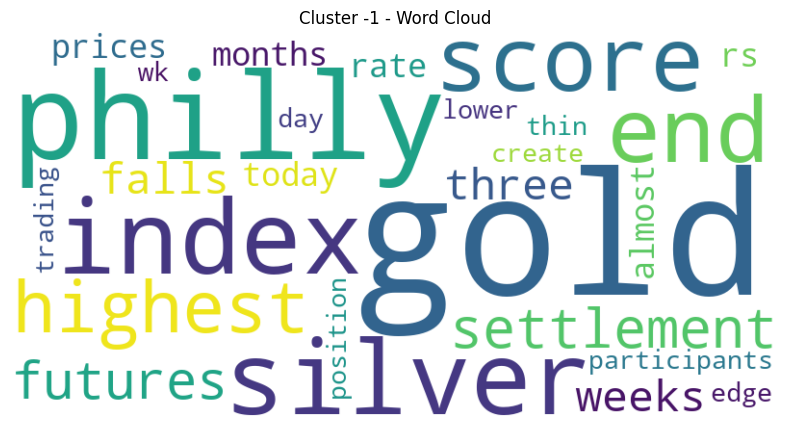


=== Cluster 0 (Size: 9563) ===

Sample Headlines:
- april gold down 20 cents to settle at $1,116.10/oz
- gold suffers third straight daily decline
- Gold futures edge up after two-session decline
- dent research : is gold's day in the sun coming soon?
- Dec. gold climbs $9.40, or 0.7%, to settle at $1,356.90/oz

Top 10 Terms:
- gold (count: 9018)
- futures (count: 1503)
- prices (count: 958)
- for (count: 829)
- after (count: 817)
- down (count: 764)
- the (count: 671)
- dollar (count: 671)
- silver (count: 631)
- gains (count: 553)


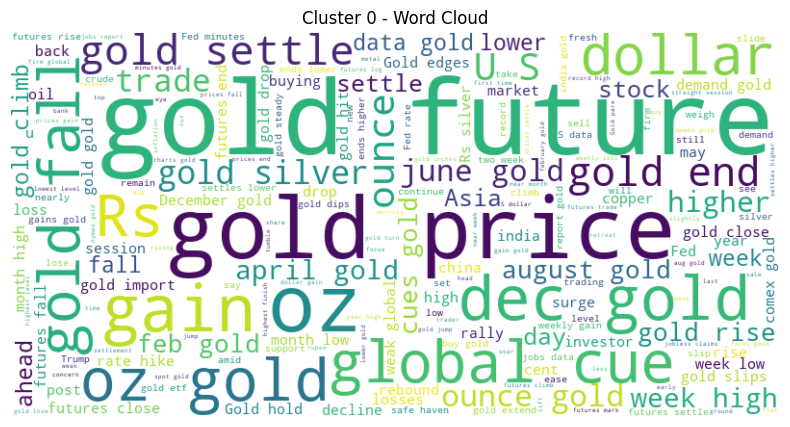


=== Cluster 1 (Size: 61) ===

Sample Headlines:
- Gold snaps three-day rally as Trump, lawmakers reach debt-ceiling deal
- Spot Gold rates move up today
- gold rate today: gold, silver down in morning trade
- today gold price: track today gold rate latest trends and news
- current gold rate: check out current gold price

Top 10 Terms:
- gold (count: 74)
- rate (count: 33)
- silver (count: 27)
- morning (count: 19)
- trade (count: 17)
- today (count: 11)
- and (count: 10)
- trends (count: 8)
- deals (count: 8)
- latest (count: 7)


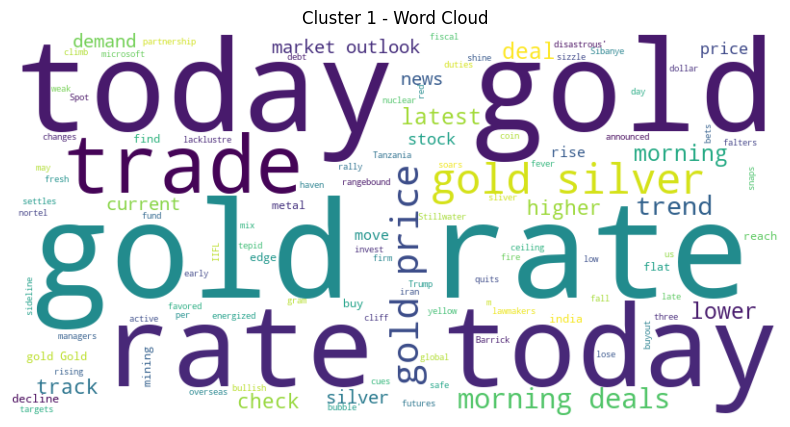


=== Cluster 2 (Size: 40) ===

Sample Headlines:
- gold to trade in 28670-29160 range: achiievers equities
- gold to trade in 28372-28686 range: achiievers equities
- gold to trade in 27287-27713 range: achiievers equities
- gold to trade in 28812-29204: achiievers equities
- gold to trade in 29646-30122 range: achiievers equities

Top 10 Terms:
- gold (count: 40)
- trade (count: 37)
- equities (count: 37)
- achiievers (count: 36)
- range (count: 2)
- trades (count: 1)
- under (count: 1)
- rise (count: 1)
- will (count: 1)
- keep (count: 1)


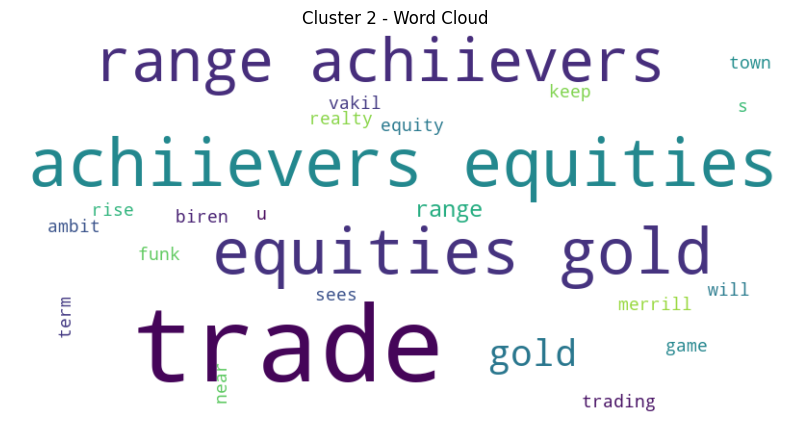


=== Cluster 3 (Size: 59) ===

Sample Headlines:
- Gold, Silver may trade lower today: Angel Commodities
- Gold prices to trade lower today: Angel Commodities
- Expect Gold to trade sideways: Sushil Finance
- gold prices to trade volatile: angel commodities
- Gold prices to trade higher today: Angel Commodities

Top 10 Terms:
- trade (count: 46)
- commodities (count: 38)
- gold (count: 38)
- angel (count: 36)
- prices (count: 30)
- may (count: 17)
- silver (count: 15)
- expect (count: 12)
- sushil (count: 9)
- finance (count: 9)


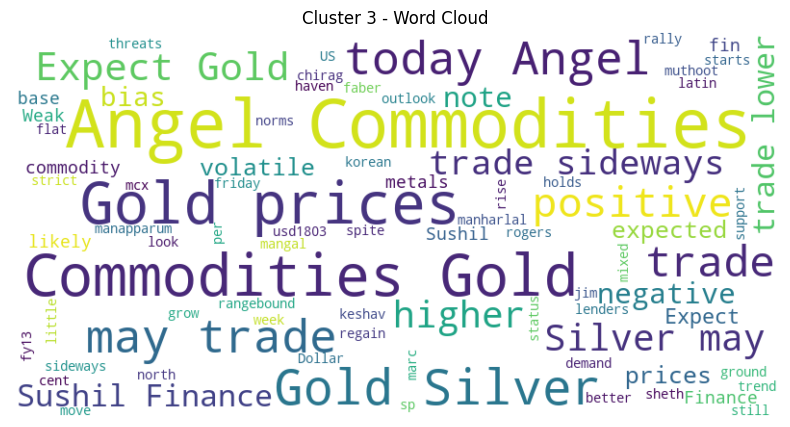


=== Cluster 4 (Size: 29) ===

Sample Headlines:
- gold little changed; copper sinks
- Gold little changed near 3-1/2-month low amid bearish chart signals
- Gold little changed amid steady dollar ahead of US jobs report
- gold little changed near 7-week low on weak technical picture
- gold little changed amid firm dollar

Top 10 Terms:
- gold (count: 29)
- little (count: 27)
- changed (count: 22)
- data (count: 8)
- prices (count: 6)
- dollar (count: 5)
- after (count: 5)
- amid (count: 4)
- eyes (count: 4)
- near (count: 3)


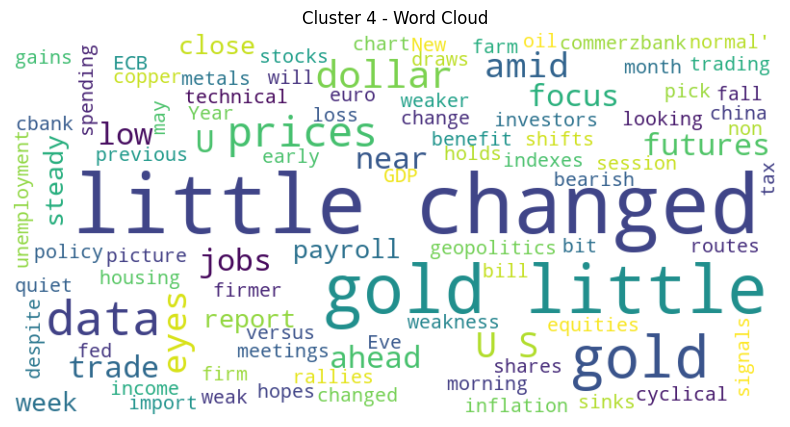


=== Cluster 5 (Size: 23) ===

Sample Headlines:
- gold futures open higher, as dollar drops
- Gold futures open higher at Rs 29,440
- Gold futures open lower at Rs 27,040
- Gold futures open lower at Rs 31,136 per 10 gm
- Gold futures open higher at Rs 30,952 per 10 gm

Top 10 Terms:
- gold (count: 22)
- open (count: 18)
- futures (count: 17)
- lower (count: 10)
- higher (count: 8)
- per (count: 4)
- opens (count: 4)
- mcx (count: 3)
- for (count: 2)
- marginally (count: 2)


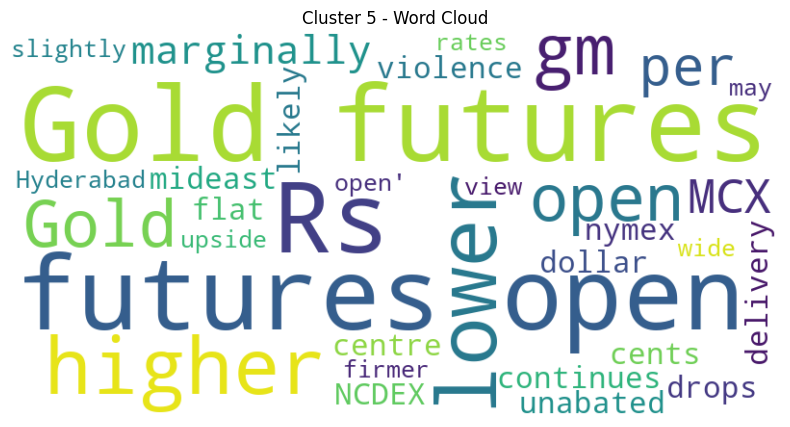


=== Cluster 6 (Size: 19) ===

Sample Headlines:
- gold prices gain in major metros in india
- gold rates slip in major cites india
- gold rates trading mixed in major metros in india
- Spot Gold rates trading higher in major metros
- Gold prices in major metros in India

Top 10 Terms:
- gold (count: 19)
- major (count: 19)
- india (count: 16)
- metros (count: 15)
- prices (count: 11)
- rates (count: 8)
- trading (count: 6)
- slip (count: 4)
- spot (count: 4)
- cities (count: 3)


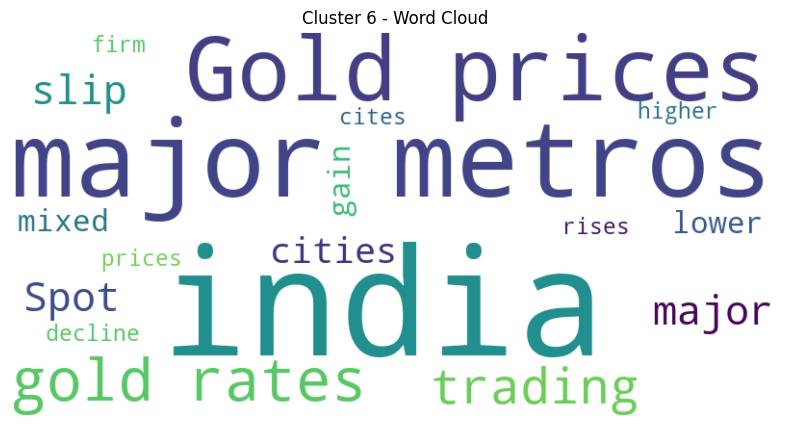


=== Cluster 7 (Size: 11) ===

Sample Headlines:
- Support for MCX Gold Feb at Rs 28800: Kotak Commodity
- Support for MCX Gold Dec at Rs 28250: Kotak Commodity
- Support for MCX Gold Dec at Rs 28350: Kotak Commodity
- MCX Gold, Silver may note some gains: Kotak Commodity
- Support for MCX Gold December at Rs 28300: Kotak Commodity

Top 10 Terms:
- mcx (count: 11)
- kotak (count: 11)
- commodity (count: 11)
- support (count: 9)
- for (count: 9)
- gold (count: 9)
- dec (count: 5)
- silver (count: 2)
- may (count: 2)
- december (count: 2)


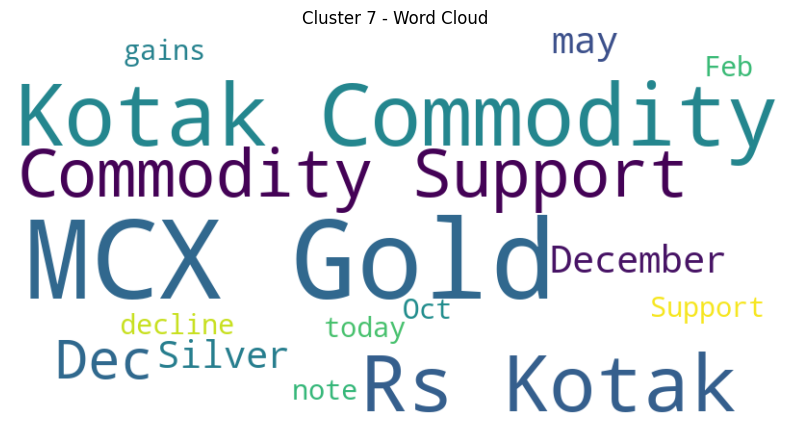


=== Cluster 8 (Size: 169) ===

Sample Headlines:
- gold rates: mcx goldguinea july contract declines
- MCX GOLD February contract moves up
- MCX GOLDPETAL Nov contract up marginally
- mcx goldguinea november contract rises
- MCX GOLD Dec contract trading lower

Top 10 Terms:
- contract (count: 163)
- mcx (count: 161)
- gold (count: 61)
- goldguinea (count: 46)
- goldpetal (count: 38)
- trades (count: 35)
- goldm (count: 29)
- gains (count: 24)
- lower (count: 23)
- trading (count: 19)


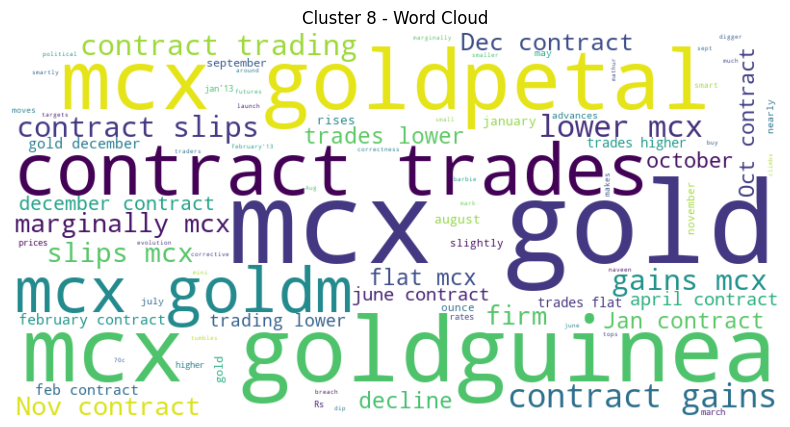


=== Cluster 9 (Size: 15) ===

Sample Headlines:
- gold shares buoy bay street
- gold, energy lead bay street rally
- gold stocks jump-start bay street
- gold, nortel weigh on bay street
- nortel, gold buoy bay street

Top 10 Terms:
- bay (count: 13)
- street (count: 13)
- gold (count: 10)
- energy (count: 4)
- shares (count: 2)
- buoy (count: 2)
- stocks (count: 2)
- weigh (count: 2)
- and (count: 2)
- lead (count: 1)


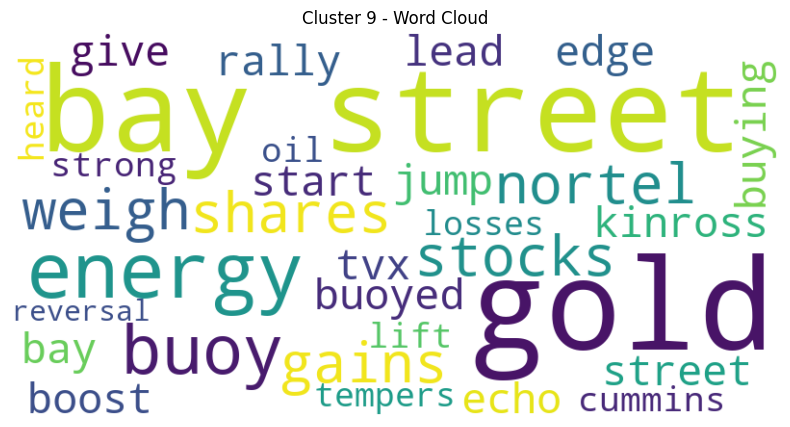


=== Cluster 10 (Size: 30) ===

Sample Headlines:
- Gold / Silver / Copper futures - weekly outlook: August 4 - 8
- Gold / Silver / Copper futures - weekly outlook: December 8 - 12
- gold / silver / copper futures - weekly outlook: may 5 - 9
- Gold / Silver / Copper futures - weekly outlook: June 9 - 13
- Gold / Silver / Copper futures - weekly outlook: April 28 - May 2

Top 10 Terms:
- copper (count: 29)
- gold (count: 28)
- silver (count: 28)
- weekly (count: 28)
- futures (count: 27)
- june (count: 6)
- august (count: 5)
- april (count: 5)
- december (count: 3)
- september (count: 3)


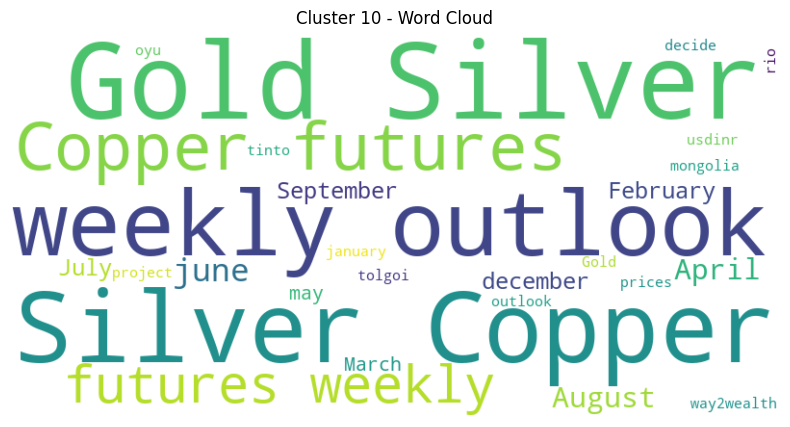


=== Cluster 11 (Size: 33) ===

Sample Headlines:
- sell mcx gold dec around rs 31500; target rs 31170: geojit
- Buy MCX Gold at Rs 28,600; Target Rs 28,900: IIFL
- sell mcx gold apr fut around rs 29620: fortune fin
- bofa keeps 12-month gold price target
- sell mcx gold feb fut around rs 31140: fortune financial

Top 10 Terms:
- gold (count: 31)
- mcx (count: 27)
- target (count: 26)
- sell (count: 18)
- buy (count: 10)
- around (count: 7)
- fut (count: 5)
- karvy (count: 5)
- dec (count: 4)
- fortune (count: 4)


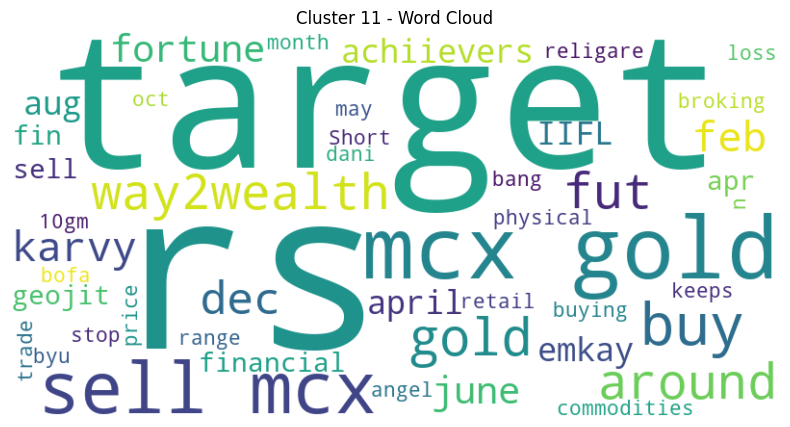


=== Cluster 12 (Size: 26) ===

Sample Headlines:
- cboe gold index closes at 84.2, up 4%
- cboe gold index closes at 141.18 points, down 0.4%
- cboe gold index up 2.9% to end at 92.91, up 4.2% on wk
- cboe gold index closes at 131.17, down 0.6%
- cboe gold index ends at 83.54, up 0.3%

Top 10 Terms:
- cboe (count: 26)
- gold (count: 26)
- index (count: 26)
- closes (count: 8)
- down (count: 7)
- highest (count: 4)
- since (count: 4)
- close (count: 4)
- falls (count: 4)
- ends (count: 3)


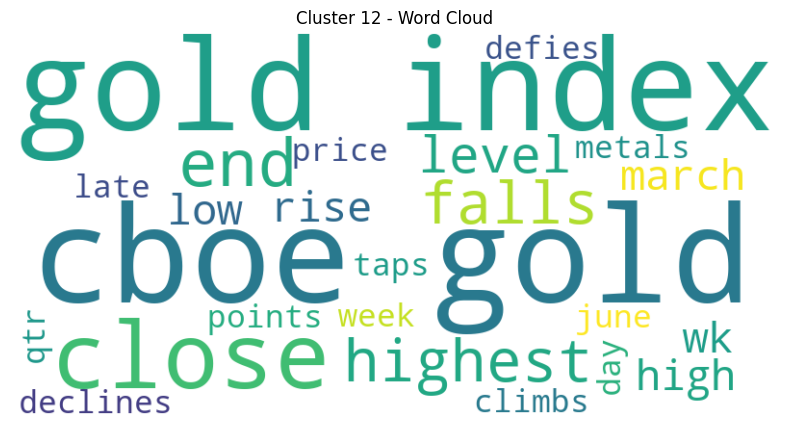


=== Cluster 13 (Size: 9) ===

Sample Headlines:
- moody's revises pilgrim's pride outlook on gold kist bid
- gold kist rejects pilgrim's pride offer as inadequate
- pilgrim's pride to acquire gold kist for $21 a share
- pilgrim's pride extends gold kist tender offer
- pilgrim's pride to launch gold kist tender at $20 a share

Top 10 Terms:
- pride (count: 9)
- gold (count: 9)
- kist (count: 9)
- offer (count: 3)
- bid (count: 2)
- share (count: 2)
- tender (count: 2)
- takeover (count: 2)
- revises (count: 1)
- outlook (count: 1)


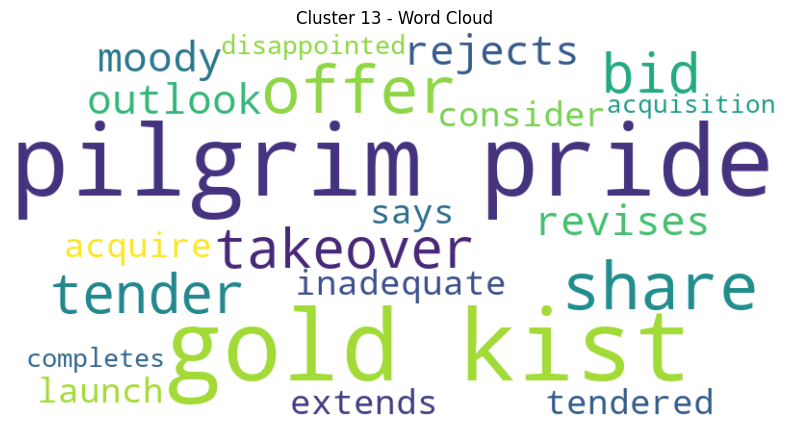


=== Cluster 14 (Size: 15) ===

Sample Headlines:
- Gold prices trading higher in Chennai, Ahmedabad market
- Gain seen in gold prices in Mumbai, Delhi market
- Spot Gold rates slip in Jaipur, Ahmd, Chennai market
- Spot Gold rates trading higher in Chennai, Jaipur market
- Gold prices down in Mumbai, Delhi, Ahmedabad market

Top 10 Terms:
- gold (count: 15)
- market (count: 12)
- prices (count: 8)
- chennai (count: 6)
- trading (count: 4)
- higher (count: 4)
- spot (count: 4)
- ahmedabad (count: 3)
- delhi (count: 3)
- rates (count: 3)


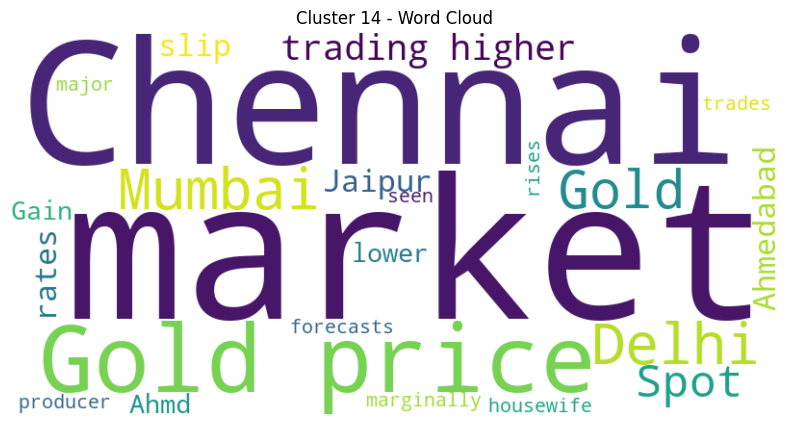


=== Cluster 15 (Size: 14) ===

Sample Headlines:
- gold slips $2.10 to settle at $1,183.50/oz
- December gold up $2.10, or 0.2%, at $1,279.80 an ounce
- December gold finishes up $2.10, or 0.2%, at $1,359.60/oz.
- dec. gold settles at $1,201.40/oz, down $2.10, or 0.2%
- December gold settles $2.10, or 0.2%, lower at $1,262.60/oz.

Top 10 Terms:
- gold (count: 14)
- down (count: 6)
- settles (count: 5)
- december (count: 3)
- slips (count: 2)
- settle (count: 2)
- globex (count: 2)
- ounce (count: 1)
- finishes (count: 1)
- lower (count: 1)


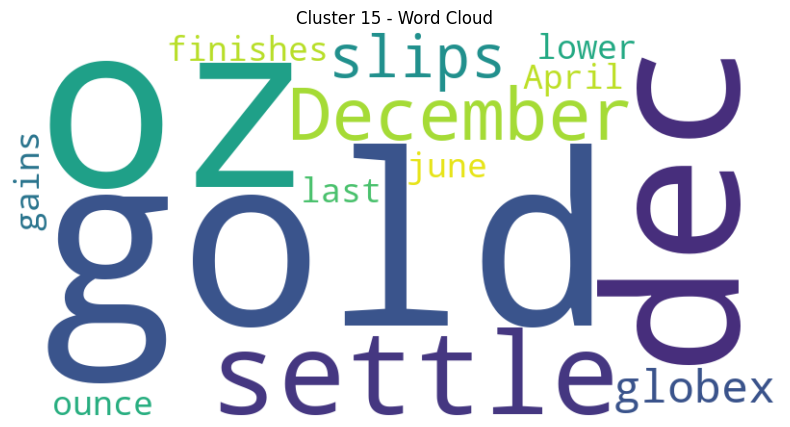


=== Cluster 16 (Size: 19) ===

Sample Headlines:
- government fixes rate at rs 2987/gm for sovereign gold bond
- Third tranche of gold bond scheme coming soon: Shaktikanta Das
- third tranche of sovereign gold bond scheme on oct 9
- fifth tranche of sovereign gold bond expected to cross rs 820 crore
- govt fixes sovereign gold bond rate at rs 2,961/gram

Top 10 Terms:
- gold (count: 18)
- sovereign (count: 16)
- bond (count: 11)
- tranche (count: 7)
- bonds (count: 7)
- fixes (count: 6)
- rate (count: 6)
- government (count: 5)
- scheme (count: 3)
- from (count: 3)


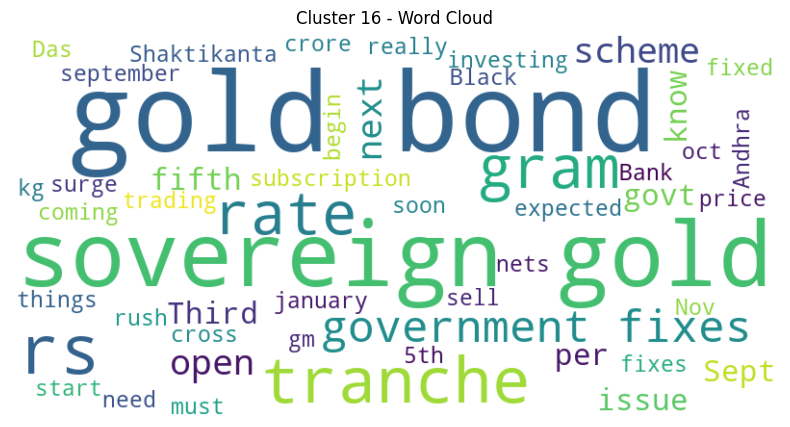


=== Cluster 17 (Size: 33) ===

Sample Headlines:
- buy gold on dips; may test rs 33250: nirmal bang
- gold may slip to rs 26500: nirmal bang
- buy gold on dips around rs 31370: nirmal bang
- buy gold around rs 30740; sl below rs 30615: nirmal bang
- nirmal bang`s view on gold, silver, copper, lead, crude

Top 10 Terms:
- nirmal (count: 31)
- bang (count: 31)
- gold (count: 23)
- may (count: 10)
- around (count: 7)
- buy (count: 6)
- expect (count: 6)
- trade (count: 5)
- test (count: 4)
- below (count: 4)


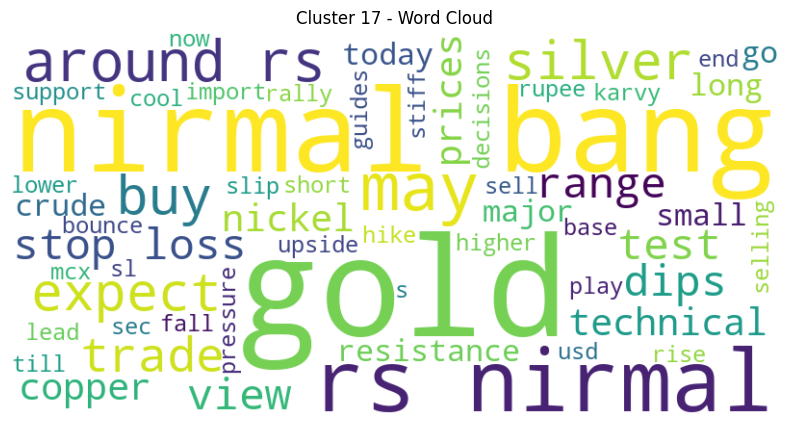


=== Cluster 18 (Size: 60) ===

Sample Headlines:
- spot gold quoted at $404.10 in asia
- spot gold quoted at $394.80, up 0.05% from ny
- spot gold quoted at $597.90 in asia trade
- spot gold quoted at $552.50 in asia trade
- spot gold quoted at $471.40 in asia trade

Top 10 Terms:
- spot (count: 60)
- gold (count: 60)
- quoted (count: 56)
- asia (count: 55)
- trade (count: 51)
- from (count: 6)
- down (count: 4)
- prices (count: 2)
- rise (count: 2)
- early (count: 1)


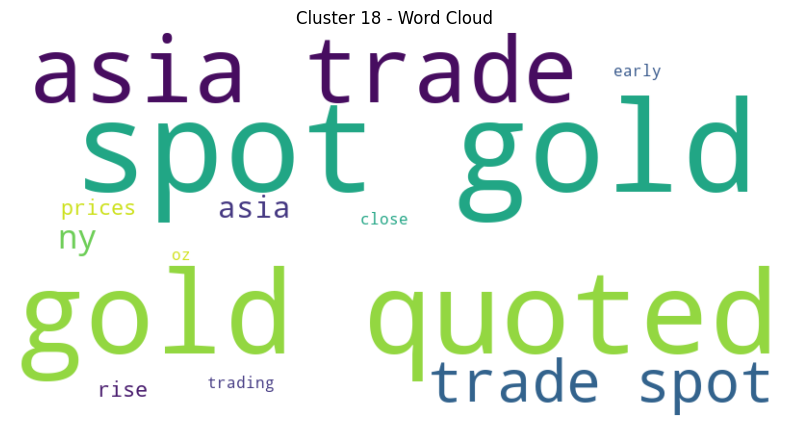


=== Cluster 19 (Size: 98) ===

Sample Headlines:
- Gold futures up at Rs 30,226/10 gm
- Gold futures down at Rs 30,383 per 10 gm
- Gold futures rise to Rs 29,000 per 10 gm
- MCX gold may touch Rs 30,080 per 10 gm
- Gold futures rise to Rs 26,502 per 10 gm

Top 10 Terms:
- gold (count: 98)
- per (count: 93)
- futures (count: 89)
- down (count: 27)
- rise (count: 17)
- decline (count: 6)
- climb (count: 5)
- jump (count: 5)
- mcx (count: 3)
- high (count: 3)


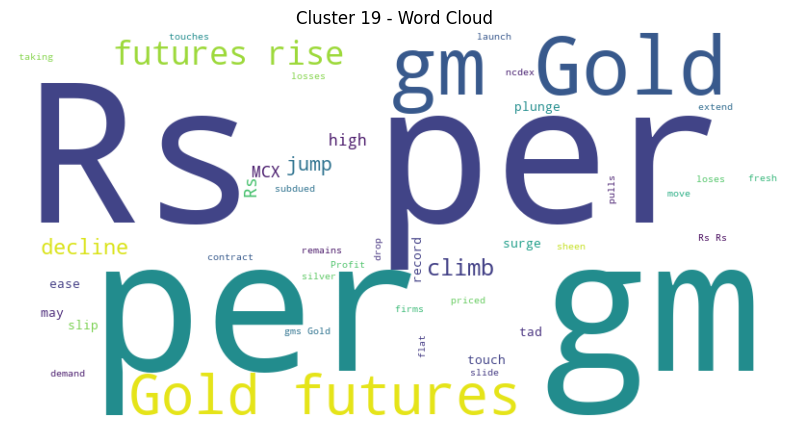


=== Cluster 20 (Size: 15) ===

Sample Headlines:
- philadelphia gold/silver index ends at 99.96, up 0.5% on day
- philadelphia gold/silver index up 2% to end at 114.47
- philadelphia gold/silver index ends near one-week high
- philadelphia gold/silver index closes at a two-month high
- philadelphia gold/silver index closes at 91.13, up 0.4%

Top 10 Terms:
- philadelphia (count: 15)
- index (count: 15)
- closes (count: 4)
- falls (count: 4)
- close (count: 4)
- ends (count: 3)
- end (count: 2)
- high (count: 2)
- down (count: 2)
- day (count: 1)


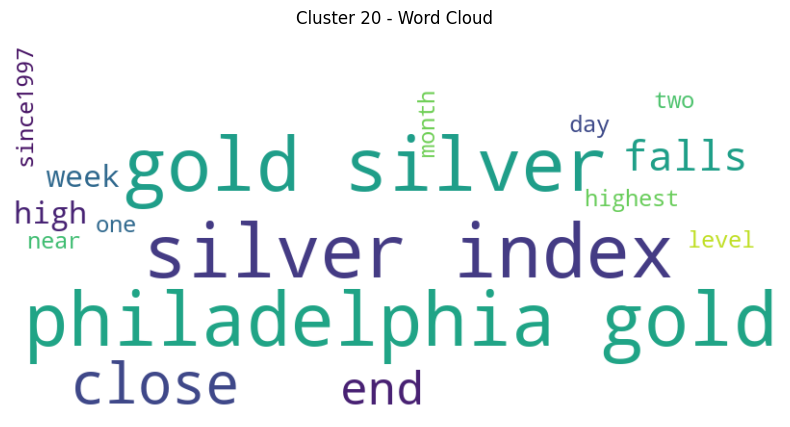


=== Cluster 21 (Size: 18) ===

Sample Headlines:
- gold stays lower after fed's beige book
- gold settles lower, extends loss after fed beige book
- april gold down $7.60, or 0.6%, to settle at $1,327.60/oz ahead of fed beige book
- Gold edges down from settlement after release of Fed Beige Book
- gold climbs past $1,090/oz in electronic trading after fed beige book

Top 10 Terms:
- gold (count: 18)
- beige (count: 18)
- book (count: 18)
- fed (count: 16)
- after (count: 14)
- electronic (count: 7)
- trade (count: 6)
- settles (count: 5)
- edges (count: 4)
- from (count: 4)


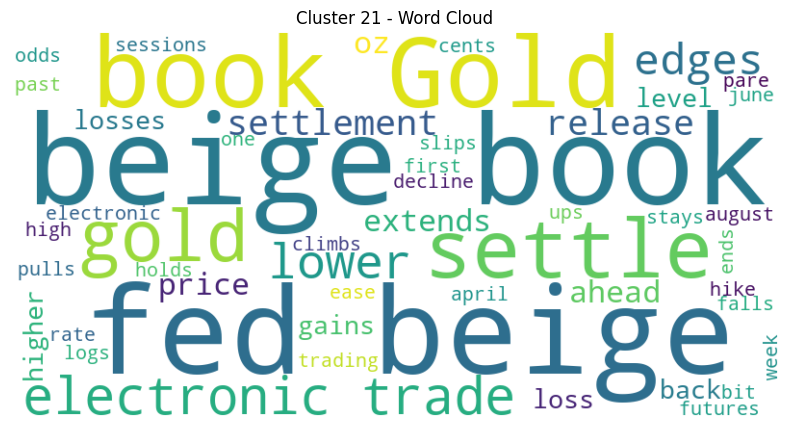


=== Cluster 22 (Size: 23) ===

Sample Headlines:
- gold rate per gram: check out current gold price per gram
- Gold futures move up to Rs 28,632 per 10 grams
- Gold futures fall to Rs 27,740 per 10 gram
- Gold at a new high of Rs 24,770/10 grams
- Gold futures down at Rs 31,231 per 10 gram

Top 10 Terms:
- gold (count: 25)
- per (count: 18)
- grams (count: 15)
- futures (count: 12)
- gram (count: 8)
- high (count: 5)
- global (count: 3)
- cues (count: 3)
- ten (count: 3)
- rate (count: 2)


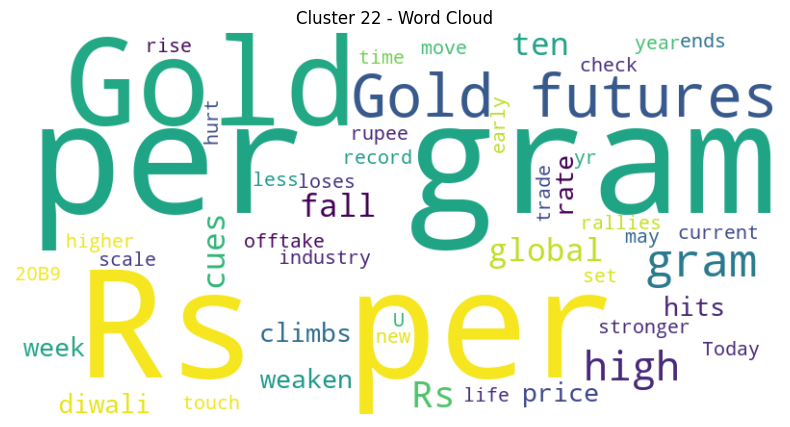


=== Cluster 23 (Size: 42) ===

Sample Headlines:
- spot gold quoted at $421.30, down 40c from new york
- spot gold quoted at $393.50, down 40c from new york
- spot gold quoted at $422.10, down 30c from new york
- spot gold quoted at $403.60, unchanged from new york
- spot gold quoted at $417.30, down 40c from new york

Top 10 Terms:
- spot (count: 42)
- gold (count: 42)
- quoted (count: 42)
- from (count: 42)
- new (count: 42)
- york (count: 42)
- down (count: 26)
- cents (count: 6)
- unchanged (count: 3)


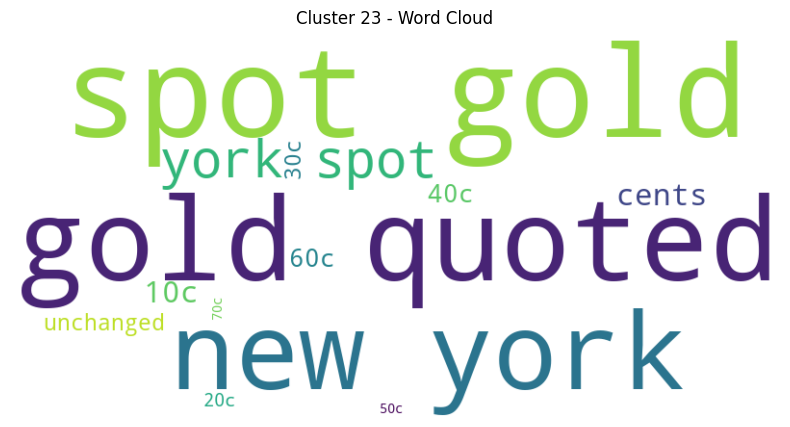


=== Cluster 24 (Size: 23) ===

Sample Headlines:
- Gold Prices Fall In Asia After Official China PMI Dampens Sentiment
- Gold prices dip in Asia on Fed views, ahead of China HSBC flash PMI
- Gold prices drop sharply in Asia on weak flash China PMI, market turmoil
- Gold dips, but copper gains on China PMI figures
- gold prices up in early asia, copper flat as hsbc china pmi ahead

Top 10 Terms:
- gold (count: 21)
- pmi (count: 19)
- china (count: 16)
- prices (count: 14)
- asia (count: 10)
- flash (count: 10)
- hsbc (count: 8)
- after (count: 6)
- copper (count: 6)
- gains (count: 4)


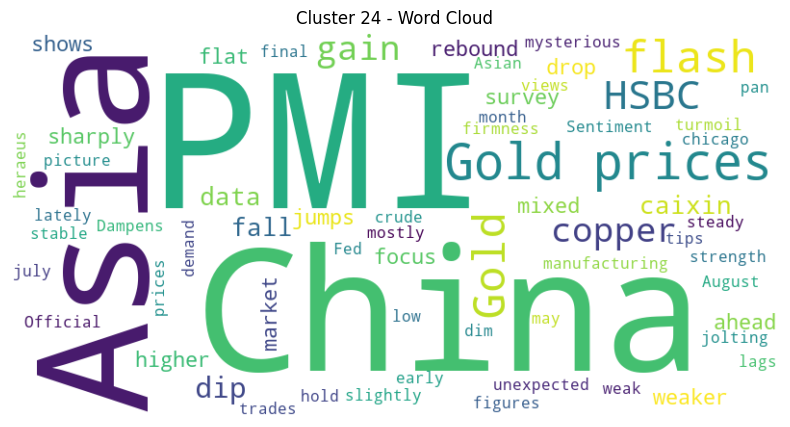


=== Cluster 25 (Size: 15) ===

Sample Headlines:
- amex gold bugs index ends at a record 393.28, up 4.6%
- amex gold bugs index falls 6.7% to close at 359.4
- amex gold bugs index down 6.6% for the week
- amex gold bugs index ends the week with an 8.3% loss
- amex gold bugs index climbs 1.1% to close at 196.07

Top 10 Terms:
- amex (count: 15)
- gold (count: 15)
- bugs (count: 15)
- index (count: 15)
- ends (count: 7)
- falls (count: 5)
- close (count: 5)
- down (count: 5)
- the (count: 4)
- week (count: 3)


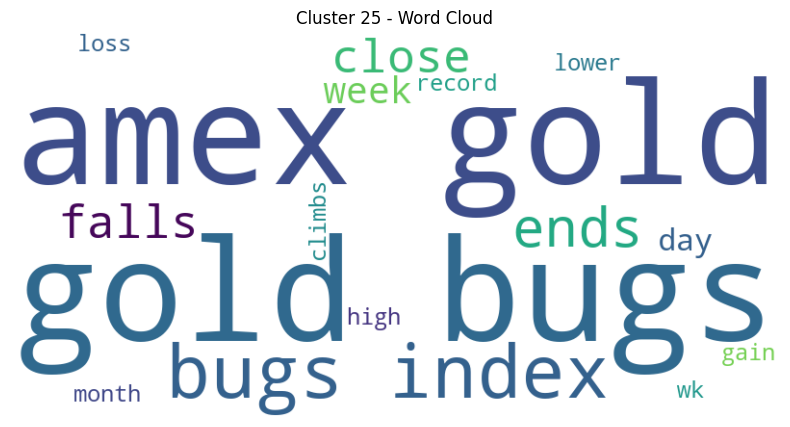


=== Cluster 26 (Size: 13) ===

Sample Headlines:
- gold futures trade at a four-session low
- dec. gold tallies four-session drop of over $44, or 7%
- gold futures log four-session climb
- gold futures head lower, on track for four-session loss
- gold prices edge up after four-session decline

Top 10 Terms:
- gold (count: 13)
- futures (count: 9)
- loss (count: 3)
- after (count: 3)
- decline (count: 3)
- tallies (count: 2)
- climb (count: 2)
- head (count: 2)
- for (count: 2)
- trade (count: 1)


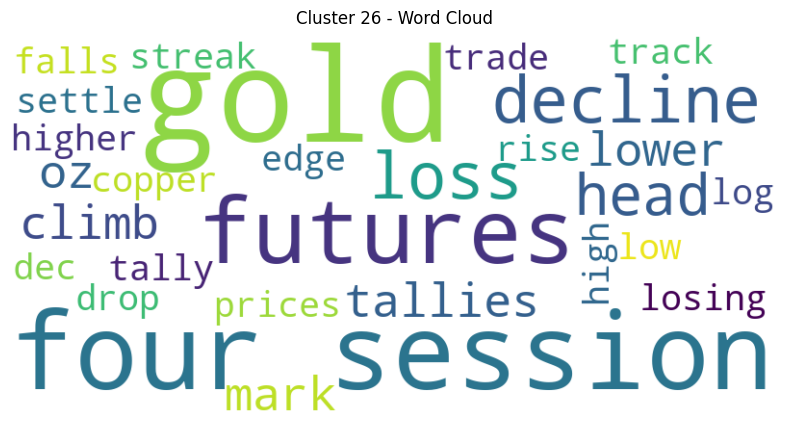


=== Cluster 27 (Size: 14) ===

Sample Headlines:
- Gold futures fall to Rs 31,144 per 10 gm
- Gold futures fall to Rs 31,167 per 10 gm
- Gold futures fall to Rs 27,861 per 10 gm
- Gold futures fall to Rs 31,395 per 10 gm
- Gold futures fall to Rs Rs 30,230 per 10 gm

Top 10 Terms:
- gold (count: 14)
- per (count: 13)
- futures (count: 12)
- fall (count: 12)
- falls (count: 2)
- sees (count: 1)
- biggest (count: 1)
- weakening (count: 1)
- trend (count: 1)


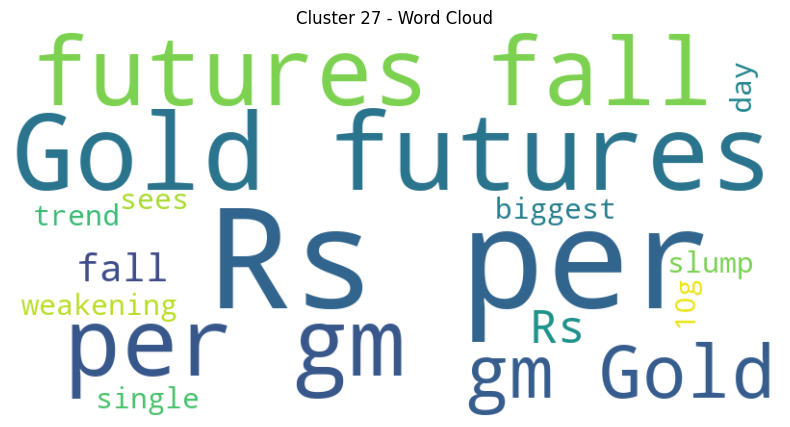


=== Cluster 28 (Size: 22) ===

Sample Headlines:
- winning week for gold leaves bugs hopeful, wary
- van eck gold bug still bullish
- gold, uranium rises vindicate 'original bug'
- amex gold bugs index closes down 0.8% at 240.73
- amex gold bugs index ends at 4-wk low of 198.79, down 1.9%

Top 10 Terms:
- gold (count: 21)
- bugs (count: 18)
- index (count: 11)
- amex (count: 10)
- closes (count: 5)
- down (count: 5)
- for (count: 3)
- ends (count: 3)
- week (count: 2)
- wary (count: 2)


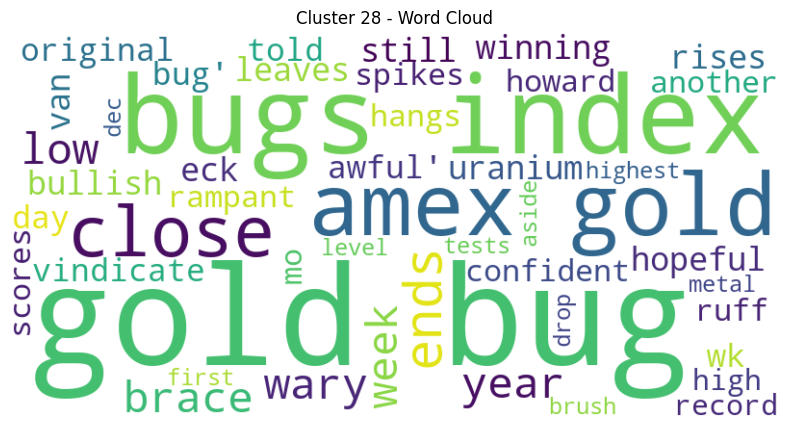


=== Cluster 29 (Size: 17) ===

Sample Headlines:
- philadelphia gold & silver index falls 2.2%
- philadelphia gold and silver index down 3.4% for week
- philadelphia gold & silver index rises 2.4%
- philadelphia gold & silver index falls 2.7%
- philadelphia gold & silver index climbs 1.8%

Top 10 Terms:
- philadelphia (count: 17)
- gold (count: 17)
- silver (count: 17)
- index (count: 17)
- falls (count: 4)
- rises (count: 4)
- and (count: 3)
- down (count: 3)
- for (count: 2)
- week (count: 2)


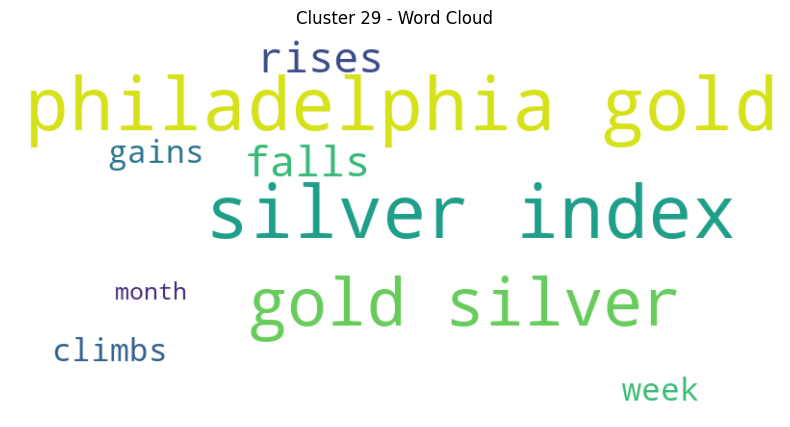


=== Cluster 30 (Size: 15) ===

Sample Headlines:
- Profit-booking pulls gold futures down to Rs 30,505 
- Gold futures fall by Rs 143 on profit-booking
- Gold moves down in futures trade on profit-booking
- gold futures decline rs 59 on profit-booking
- Gold futures down 0.19% on profit-booking

Top 10 Terms:
- gold (count: 15)
- futures (count: 15)
- down (count: 8)
- pulls (count: 6)
- fall (count: 2)
- trade (count: 2)
- decline (count: 2)
- moves (count: 1)
- falls (count: 1)
- weaken (count: 1)


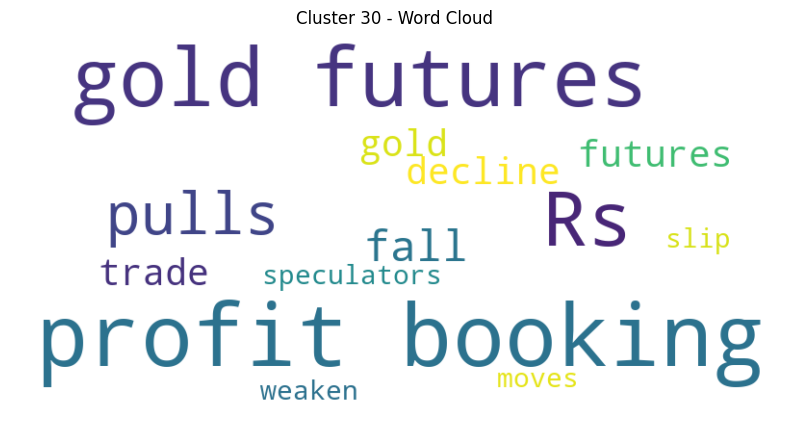


=== Cluster 31 (Size: 18) ===

Sample Headlines:
- gold futures settle at an almost three-week high
- gold futures climb to a three-week high
- feb. gold at three-week low, down $10 on globex
- gold recovers from a three-week low to end slightly higher
- Gold futures settle at a nearly three-week high

Top 10 Terms:
- gold (count: 17)
- high (count: 9)
- futures (count: 7)
- settle (count: 4)
- from (count: 4)
- low (count: 4)
- settles (count: 4)
- higher (count: 3)
- nearly (count: 3)
- dollar (count: 3)


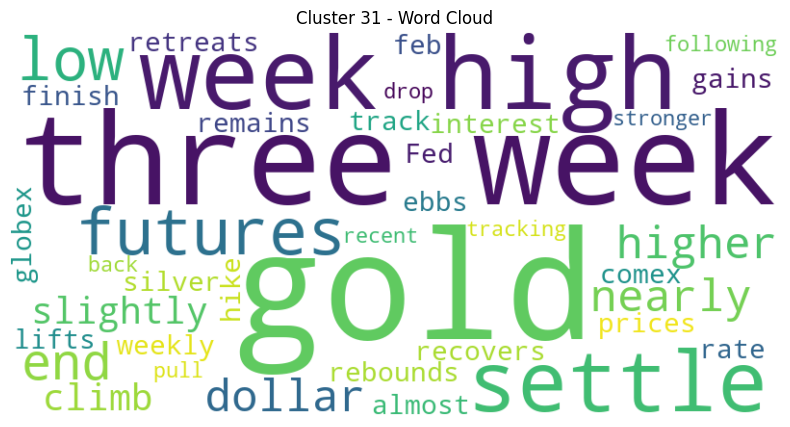

In [21]:
from collections import Counter


def analyze_clusters(df, n_samples=5):
    # Group by cluster
    clusters = df.groupby("cluster")

    for cluster_id, group in clusters:
        if cluster_id == -1:
            print("\n=== Noise/Outliers ===")
        else:
            print(f"\n=== Cluster {cluster_id} (Size: {len(group)}) ===")

        # Print sample headlines
        print("\nSample Headlines:")
        for headline in group["News"].head(n_samples):
            print(f"- {headline}")

        # Show most frequent words
        words = " ".join(group["News"]).lower().split()
        common_words = [
            word for word in words if word.isalpha() and len(word) > 2
        ]  # Filter short/non-alphabetic
        word_counts = Counter(common_words).most_common(10)

        print("\nTop 10 Terms:")
        for word, count in word_counts:
            print(f"- {word} (count: {count})")

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
            " ".join(group["News"])
        )
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Cluster {cluster_id} - Word Cloud")
        plt.show()


# Run analysis
analyze_clusters(gold_df)